### Matrix Product States

In [1]:
import numpy as np
import scipy as sp

from ED_Functions import vec_norm,Hamiltonian_TFIM_open,groundState_Krylov

import time
import matplotlib.pyplot as plt

#### MPS

In [2]:
def get_mps(psi,N,bondDim = 1e10):
    
    A,alpha = [],[1]
    k = 2
    R = psi.copy()
    for i in range(N):
        R = R.reshape((k,-1))
        
        U,S,Vh = sp.linalg.svd(R,full_matrices=False)
        k = len(S)
        
        if(k>bondDim):
            k = bondDim
            U = U[:,:bondDim]
            S = S[:bondDim]
            Vh = Vh[:bondDim,:]
        
        #A.append(U.reshape((2,k,-1)))
        A.append(U)
        alpha.append(k)
        
        k *= 2
        R = np.diag(S)@Vh
        
    return A,alpha[:-1]
def convert_to_tensor(mps,X):
    #a = []
    #for m,x in zip(mps,X):
    #    a.append(m.reshape(2,x,-1))
    return [a.reshape(2,x,-1) for a,x in zip(mps,X)]
    #return a

def get_TT(psi,N,bondDim = 1e10):
    mps,alpha = get_mps(psi,N,bondDim)
    TT = convert_to_tensor(mps,alpha)
    
    return TT

def get_shapes(psi):
    return [x.shape for x in psi]

#### Orthogonality

In [3]:
def checkOrthogonalMPS(mps,threshold = 1e-14):
    for A in mps:
        M = A.T @ A
        if not np.allclose(M, np.eye(M.shape[0]), atol=threshold):
            print(A.shape,M.shape)
            return False
    return True
    
def checkOrthogonalT(T,threshold = 1e-14):
    for t in T:        
        x = t[0].conj().T @ t[0] + t[1].conj().T @ t[1]
        if not np.allclose(x,np.eye(*x.shape), atol = threshold):
            return False
    return True

#### PROBLEM 1

In [4]:
J,g,N = 1,0.5,8
L = 50

H,basis = Hamiltonian_TFIM_open(J,g,N,return_basis=True)

gs,psi = groundState_Krylov(J,g,N,L)
psi = psi/vec_norm(psi)

In [5]:
psi_mps,psi_mps_alpha = get_mps(psi,N,10)
[(x.shape,z) for x,z in zip(psi_mps,psi_mps_alpha)]

[((2, 2), 1),
 ((4, 4), 2),
 ((8, 8), 4),
 ((16, 10), 8),
 ((20, 8), 10),
 ((16, 4), 8),
 ((8, 2), 4),
 ((4, 1), 2)]

In [6]:
checkOrthogonalMPS(psi_mps)

True

In [7]:
psi_mps_T = convert_to_tensor(psi_mps,psi_mps_alpha)
[a.shape for a in psi_mps_T]

[(2, 1, 2),
 (2, 2, 4),
 (2, 4, 8),
 (2, 8, 10),
 (2, 10, 8),
 (2, 8, 4),
 (2, 4, 2),
 (2, 2, 1)]

In [8]:
checkOrthogonalT(psi_mps_T)

True

In [42]:
rng = np.random.default_rng(seed = 123)

N,bondDim = 3,10
#psi_random = rng.random(2**N)
#psi_random = psi_random/vec_norm(psi_random)

psi_random = np.zeros(2**N)
psi_random[5] = 1
print(psi_random)

psi_random_mps,psi_random_mps_alpha = get_mps(psi_random,N,bondDim)
print("MPS: ",[x.shape for x in psi_random_mps])
print("Orthogonal:", checkOrthogonalMPS(psi_random_mps))
psi_random_T = convert_to_tensor(psi_random_mps,psi_random_mps_alpha)
print("MPS as Tensors: ",[a.shape for a in psi_random_T])
print("Bond Dimension w/o Compression: ",max(max(*[x.shape for x in psi_random_T])),2**(N//2))
print(psi_random_mps)
psi_random_T

[0. 0. 0. 0. 0. 1. 0. 0.]
MPS:  [(2, 2), (4, 2), (4, 1)]
Orthogonal: True
MPS as Tensors:  [(2, 1, 2), (2, 2, 2), (2, 2, 1)]
Bond Dimension w/o Compression:  2 2
[array([[0., 1.],
       [1., 0.]]), array([[1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.]]), array([[0.],
       [1.],
       [0.],
       [0.]])]


[array([[[0., 1.]],
 
        [[1., 0.]]]),
 array([[[1., 0.],
         [0., 1.]],
 
        [[0., 0.],
         [0., 0.]]]),
 array([[[0.],
         [1.]],
 
        [[0.],
         [0.]]])]

#### Overlap

In [29]:
def mps_overlap(a,b = None,rightCann = False):
    if(rightCann):
        a = a[::-1]
        
    if(b is None):
        b = a.copy()
    
    assert len(a) == len(b)
    
    L = np.array([[1]])

    for i in range(len(a)):
        #print("IN LOOP",L.shape)
        L = (a[i][0].conj().T @ L @ b[i][0]) + (a[i][1].conj().T @ L @ b[i][1])
    print(L.shape)
    return L

#### PROBLEM 2 b

In [33]:
mps_overlap(psi_mps_T.copy(),psi_mps_T.copy())#,mps_overlap(psi_random_T)

(1, 1)


array([[1.]])

In [12]:
N_2b,bondDim_2b = 10,10

rng = np.random.default_rng(seed = 22)
psi_2b = rng.random(2**N)

#J,g,N = 1,0.5,8
#L = 50
#H,basis = Hamiltonian_TFIM_open(J,g,N,return_basis=True)
#gs,psi_2b = groundState_Krylov(J,g,N,L)


psi_2b = psi_2b/vec_norm(psi_2b)


psi_2b_mps,psi_2b_alpha = get_mps(psi_2b,N_2b,bondDim_2b)
psi_2b_T = convert_to_tensor(psi_2b_mps,psi_2b_alpha)

print(f'Sites : {N_2b} ; Maximum Bond Dim : {bondDim_2b}')
print("Tensor Dimensions: ")
print([x.shape for x in psi_2b_T])
print("Orthogonal: ",checkOrthogonalMPS(psi_2b_mps),checkOrthogonalT(psi_2b_T))
print("Self Overlap: ", mps_overlap(psi_2b_T))

Sites : 10 ; Maximum Bond Dim : 10
Tensor Dimensions: 
[(2, 1, 2), (2, 2, 4), (2, 4, 8), (2, 8, 10), (2, 10, 10), (2, 10, 10), (2, 10, 8), (2, 8, 4), (2, 4, 2), (2, 2, 1)]
Orthogonal:  True True
Self Overlap:  [[1.]]


In [78]:
def variationOfOverlap(J1,g1,J2,g2,N,L,bondDim = 1000):
    #H1 = Hamiltonian_TFIM_open(J1,g1,N)
    gs_1,psi_1 = groundState_Krylov(J1,g1,N,L)
    psi_1 = psi_1/vec_norm(psi_1)

    #H2 = Hamiltonian_TFIM_open(J2,g2,N)
    gs_2,psi_2 = groundState_Krylov(J2,g2,N,L)
    #psi_2 = -psi_1.copy()
    psi_2 = psi_2/vec_norm(psi_2)

    plt.plot(psi_1**2,label = gs_1)
    plt.plot(psi_2**2,alpha = 0.7, label = gs_2)

    psi_1_TT,_ = get_complete_mps(psi_1,N,bondDim)
    psi_2_TT,_ = get_complete_mps(psi_2,N,bondDim)

    #print(get_shapes(psi_1_TT),'\n',get_shapes(psi_2_TT))
    print(psi_1.conj().T @ psi_2)
    ovlp = mps_overlap(psi_1_TT,psi_2_TT)

    plt.legend(title = f"Overlap = {ovlp}")
    return ovlp

0.833660641806407
(1, 1)


array([[-0.28277211]])

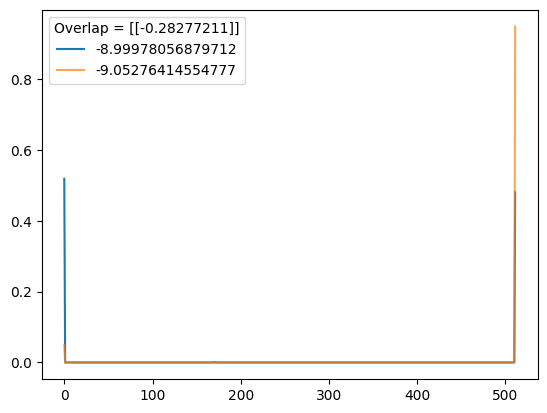

In [83]:
## For Same values of J and g - Overlap should be near 1
# But MPS is not unique

variationOfOverlap(1,0,1,0,9,150)

In [77]:
def get_complete_mps(psi,N,bondDim = 1e10):
    A, B  = [],[]

    alpha = 1
    k = 2
    R = psi.copy()

    right_dim = 2**(N-1)
    for i in range(N):
        
        R = R.reshape((k,-1))
        
        U,S,Vh = sp.linalg.svd(R,full_matrices=False)
        k = len(S)
        #print("R = ",R,"U = ",U,"S = ",S,"Vh =", Vh,sep = '\n')
        #print("------------------------------")
        if(k>bondDim):
            k = bondDim
            U = U[:,:bondDim]
            S = S[:bondDim]
            Vh = Vh[:bondDim,:]
        
        A.append(U.reshape(2,alpha,-1))
        alpha = k
        
        k *= 2
        right_dim //= 2
        R = np.diag(S)@Vh

    alpha = 1
    k = 2
    L = psi.copy()
    
    #for i in range(N,0,-1):
    #    L = L.reshape((k,-1))
    #    U,S,Vh = sp.linalg.svd(L,full_matrices=False)
#
    #    
    #    k = len(S)
#
    #    if(k>bondDim):
    #        k = bondDim
    #        U = U[:,:bondDim]
    #        S = S[:bondDim]
    #        Vh = Vh[:bondDim,:]
#
    #    B.append(Vh.T.reshape((2,alpha,-1)))
    #    alpha = k
    #    k *= 2
    #    L = U@np.diag(S)
    #    
    #B = B[::-1]
    #print([a.shape for a in A])
    #print([b.shape for b in B])
    return A,B

In [16]:
rng = np.random.default_rng(seed = 123)

N,bondDim = 6,5
psi_random = rng.random(2**N)
psi_random = psi_random/vec_norm(psi_random)

psi_random_mps_a,psi_random_mps_b = get_complete_mps(psi_random,N,bondDim)

print(checkOrthogonalT(psi_random_mps_a),checkOrthogonalT(psi_random_mps_b))
mps_overlap(psi_random_mps_b,rightCann=True)

True True


array([[1.]])

In [17]:
Sx = np.array([[0,1],[1,0]], dtype = float)

def operator(operator,site,mps):
    L,R = mps

    shape = L[site].shape
    print(shape)
    O_psi = L[:site] + [((operator@(L[site].reshape(2,-1))).reshape(shape))]  + L[site+1:]
    print(get_shapes(L))
    print(get_shapes(O_psi))
    return mps_overlap(O_psi,L)
    

In [18]:
rng = np.random.default_rng(seed = 234)

N,bondDim = 6,100
psi_operator = rng.random(2**N)
psi_operator = psi_operator/vec_norm(psi_operator)

psi_operator_mps_L,psi_operator_mps_R = get_complete_mps(psi_operator,N,bondDim)

operator(Sx,2,(psi_operator_mps_L,psi_operator_mps_R))

(2, 4, 8)
[(2, 1, 2), (2, 2, 4), (2, 4, 8), (2, 8, 4), (2, 4, 2), (2, 2, 1)]
[(2, 1, 2), (2, 2, 4), (2, 4, 8), (2, 8, 4), (2, 4, 2), (2, 2, 1)]


array([[-0.56329459]])

In [74]:
x = np.zeros(2**3)
x[5] = 1
L,R = get_complete_mps(x,3,2)
mps_overlap(L,L)
L

R = 
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]]
U = 
[[0. 1.]
 [1. 0.]]
S = 
[1. 0.]
Vh =
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]]
------------------------------
R = 
[[0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
U = 
[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]]
S = 
[1. 0.]
Vh =
[[ 0.  1.]
 [-1.  0.]]
------------------------------
R = 
[[0.]
 [1.]
 [0.]
 [0.]]
U = 
[[0.]
 [1.]
 [0.]
 [0.]]
S = 
[1.]
Vh =
[[1.]]
------------------------------


[array([[[0., 1.]],
 
        [[1., 0.]]]),
 array([[[1., 0.],
         [0., 1.]],
 
        [[0., 0.],
         [0., 0.]]]),
 array([[[0.],
         [1.]],
 
        [[0.],
         [0.]]])]

In [ ]:
mps_overlap(L,L)